# preliminaries

## load packages

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#file system
import os
import glob

#data handling
import numpy as np
import pandas as pd

#plotting
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt

# custom code
from src import features, annotation, parameters, segmentation, spectrogramming


## define path variables

In [33]:
#paths to raw data
all_wav_raw = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/'
all_wav_bw_po_cf = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/bw_po_cf/'
all_wav_bw_po_f1 = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/bw_po_f1/'
all_wav_bw_po_f2 = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/bw_po_f2/'

#paths to clips for developmental dataset
all_voc_clips_dirs = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/development/final_20220817/vocalization_clips/'
all_bg_clips_dirs = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/development/final_20220817/background_clips/'

#root directory for all of the segments (start and stop times)
segments_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/segments/'
clips_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/'
specs_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/'
noise_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/noise/'
snr_clipping_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/snr_clipping/amplitude_segmented/'
noise_floors_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/noise/all_noise_floors.csv'

#csv of annotated segments (start and stop times) from the development dataset
test_set_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/annotated/annotations_csv/all_annotations.csv'

#amplitdue segments
amplitude_acoustic_features = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/acoustic_features/amplitude_segmented/development/20220913_063001/'
amplitude_umap = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/amplitude_segmented/final/umap_coordinates/'
amplitude_umap_HDBSCAN_labeled = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'
amplitude_segments_csv = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/segments/amplitude_segmented/final/all_predictions.csv'
amplitude_voc_clips = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/development/final_20220817/vocalization_clips/'
amplitude_bg_clips = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/development/final_20220817/background_clips/'



# Figure 1

## color UMAP by HDBSCAN cluster (Figure 1C top)

### collect UMAP data

In [4]:
#choose the directories you want and print the embeddings you have available to plot
coords_dir = amplitude_umap_HDBSCAN_labeled
coords_list = os.listdir(coords_dir)

print('coordinates available...')
for i in coords_list: 
    print(i)

coordinates available...
SW
BK
LL
LO
all_species_HDBSCAN_labels.csv
MU
PO
NB
all_species_HDBSCAN_labels.feather
MZ
BW
GO


In [42]:
#choose species decide what to save
species = 'MZ'
save_umap_plot = False
save_labeled_umap_plot = False
save_label_verification = False

#load the coordinates
coords_path = glob.glob(coords_dir+species+'/*labeled.feather')[0]
df_umap = pd.read_feather(coords_path)

#just get the coordinates
df_umap_small = df_umap[['umap1', 'umap2', 'source_file', 'label']]


### plot with HDBSCAN labels

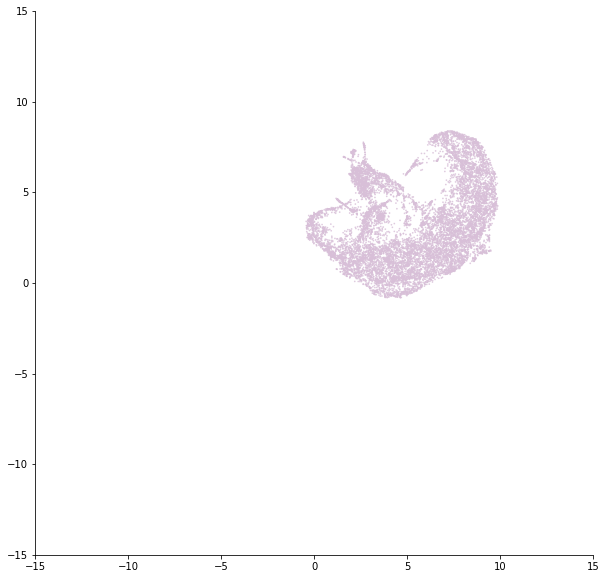

In [43]:
#decide to save or not
save_labeled_umap_plot = False

#show the umap plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

if species in ['MU', 'MZ']: #color dictionary for MU and MZ - make points ignored by HDBSCAN the same color as the
                            #the ones it considered "clusters"
    HDBSCAN_color_dict = {0: 'thistle', 
                          -1:'thistle'}
else: #color dictionary for Peromyscus taxa
    HDBSCAN_color_dict = {0: 'thistle', 
                          1: 'deeppink'}

colmap = df_umap['label'].map(HDBSCAN_color_dict)

ax = plt.scatter(
    df_umap['umap1'],
    df_umap['umap2'],
    c = colmap,
    s = .5,
    alpha = .75, 
    cmap=None)

xlims = [-15,15]
ylims = [-15,15]
plt.xlim(xlims)
plt.ylim(ylims)
sns.despine()

if save_labeled_umap_plot:
    save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/amplitude_segmentation/final/umap_plots/'
    save_name = ('_').join([species,'final_amplitude_HDBSCAN_labeled_umap.jpeg'])
    plt.savefig(os.path.join(save_dir,save_name),dpi=600)

plt.show()


## Average spectrograms (Figure 1C middle/bottom)

In [44]:
#set the path to the vocalization clips and make sure it exists
clips_dir = os.path.join(amplitude_voc_clips, species)
assert os.path.exists(clips_dir)

#get path to each wav clip
all_files = [os.path.join(clips_dir,i) for i in df_umap['source_file']]

In [48]:
os.path.join(amplitude_voc_clips, species)

'/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/development/final_20220817/vocalization_clips/MZ'

In [45]:
#set the spectrogram parameters
spec_params = {
    'min_freq': 5000, # minimum frequency
    'max_freq': 125000, # maximum frequency
    'nperseg': 512, # FFT
    'noverlap': 512 // 4, # FFT
    'spec_min_val': 0.5, # minimum log-spectrogram value - update from noise floors if noise_floors_path provided
    'fs': 250000, # audio samplerate
    'fill_value': 0.5,
    'max_duration':0.5, #set the max duration of each spectrogram to 0.5 seconds for all vocs and species
    'num_time_bins':256,
    'num_freq_bins':256,
    'spec_max_val':10
}

In [46]:
#generate the spectrograms

if species not in ['MU', 'MZ']: #if there are two clusters, generate spectrograms separately for each one
    
    label_0_files = [os.path.join(clips_dir,i) for i in df_umap['source_file'].loc[df_umap['label'] == 0]]
    label_1_files = [os.path.join(clips_dir,i) for i in df_umap['source_file'].loc[df_umap['label'] == 1]]
    
    #get the label 0 specs
    label_0_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = label_0_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')

    #get the label 1 specs
    label_1_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = label_1_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')


else:
    #get all the specs
    all_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                        noise_floors_path=noise_floors_path, 
                                                        species = None, 
                                                        filtered_clips = all_files,
                                                        noise_floor = None,
                                                        spec_params=spec_params, 
                                                        num_to_process = 'all')


generating specs from the paths in the list filtered_clips...
processesing using the noise floors provided in noise_floors_path...
making spectrograms...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12045/12045 [04:21<00:00, 46.07it/s]

done.


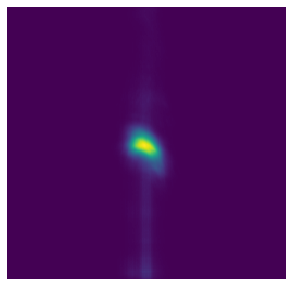

In [50]:
save = False

############################################################################################################

if species not in ['MU', 'MZ']: 
    
    #average the spectrograms you just generated
    label0_spec_avg = spectrogramming.spec_avg_from_list(label_0_specs_list)
    label1_spec_avg = spectrogramming.spec_avg_from_list(label_1_specs_list)

    #set up the figure
    fig, axes = plt.subplots(nrows=2, 
                             ncols=1, 
                             figsize=(5,10))
    
    
    #plot label 0 average
    axes[0].set_axis_off()
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    axes[0].matshow(label0_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")
    
    #plot label 1 average
    axes[1].set_axis_off()
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    axes[1].matshow(label1_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")
    
    #save 
    if save:
        save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/amplitude_segmentation/final/umap_plots/'
        save_name = ('_').join([species,'_HDBSCAN_all_vocs_common_duration.jpeg'])
        plt.savefig(fname=save_dir+save_name, dpi=600)
    
else: 
    
    #average the spectrograms you just generated
    all_spec_avg = spectrogramming.spec_avg_from_list(all_specs_list)

    #set up the figure
    fig, axes = plt.subplots(nrows=1, 
                             ncols=1, 
                             figsize=(5,5))
    
    
    #plot label 0 average
    axes.set_axis_off()
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    axes.matshow(all_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")

    #save 
    if save:
        save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/amplitude_segmentation/final/umap_plots/'
        save_name = ('_').join([species,'_HDBSCAN_all_vocs_common_duration.jpeg'])
        plt.savefig(fname=save_dir+save_name, dpi=600)
    
    

## average spectrogram by cluster (Figure 1C)

## coloted by feature (Supp. Figure ##)

## Collect data

## Figure 1 panel D

## Figure 1 panel E

## Figure 1 panel F

# Figure 2

## collect data

## evaluate vocalization type model (Supplemental Figure ## Panel ##)

## predict vocalization labels from features 

## general average spectrograms by label (Supplemental Figure ## Panel ##)

## aggregate labeled vocalizations by pup

## get annotated vocalizations for species comparisons

## features PCA (Supplemental Figure ##)

### run PCA

### scatter plots

### violin plots

## species comparisons (Figure 2C)

# Figure 4 (cross foster experiments)

## collect data

## PCA

## plot

# Figure 5 (F1 and F2 experiments)

## collect data

## PCA

## plot

# Supplemental Figure ## (more UMAP)

## color UMAP by acoustic feature

In [51]:
#choose the directories you want and print the embeddings you have available to plot
coords_dir = amplitude_umap_HDBSCAN_labeled
coords_list = os.listdir(coords_dir)

print('coordinates available...')
for i in coords_list: 
    print(i)

coordinates available...
SW
BK
LL
LO
all_species_HDBSCAN_labels.csv
MU
PO
NB
all_species_HDBSCAN_labels.feather
MZ
BW
GO


In [109]:
#choose species decide what to save
species = 'BW'

save_umap_plot = False
save_labeled_umap_plot = False
save_label_verification = False

#load the coordinates
coords_path = glob.glob(coords_dir+species+'/*labeled.feather')[0]
df_umap = pd.read_feather(coords_path)

#just get the coordinates
df_umap_small = df_umap[['umap1', 'umap2', 'source_file', 'label']]


In [110]:
#merge UMAP coordinates with acoustic features

#the features csv for this species
features = pd.read_csv(glob.glob(os.path.join(amplitude_acoustic_features, species+'*'))[0])

#merge
df_umap_features = df_umap_small.merge(features, on= 'source_file')
df_umap_features['pup'] = [i.split('_clip')[0] for i in df_umap_features['source_file']]
df_umap_features['pupID'] = pd.factorize(df_umap_features['pup'])[0]
df_umap_features['age'] = [int(i.split('_')[10][1:]) for i in  df_umap_features['pup']]
df_umap_features['duration'] = df_umap_features['duration']*1000

/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


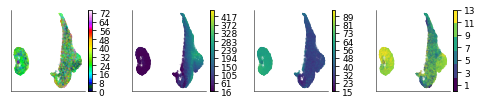

In [111]:
#plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib as mpl

save = False
save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_1/supplement/'


colors = ['pupID', 'duration', 'meanfreq', 'age']
df = df_umap_features
fontsize= 9

fig, axes = plt.subplots(nrows =1, 
                         ncols = len(colors), 
                         figsize = [8,1.5], 
                         constrained_layout=True, 
                         sharex=True, 
                         sharey=True)

fig.subplots_adjust(wspace=0.5)


for color, i in zip(colors, range(len(colors))):
    
    if color == 'pupID':
        cmap = 'gist_ncar'
    else:
        cmap = 'viridis'
    
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
#     axes[i].set_xlim([-17,13])
#     axes[i].set_ylim([-10,20])
    
    im = axes[i].scatter(
        df['umap1'],
        df['umap2'],
        c = df[color],
        s = .1,
        alpha = .25, 
        cmap=cmap)
    
    for label in (axes[i].get_yticklabels() + axes[i].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    for axis in ['top','bottom','left','right']:
        axes[i].spines[axis].set_linewidth(.5)
        
 
    if color == 'pupID':
        bounds = np.linspace(0, np.max(df['pupID']), np.max(df['pupID'])+1)
        cmap = cm.get_cmap('gist_ncar')
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                     cax=cax, 
                     orientation='vertical')
        cbar.ax.tick_params(labelsize=9) 
        
    elif color == 'age':
        bounds = np.linspace(0, 13, 7)
        cmap = cm.get_cmap('viridis')
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                     cax=cax, 
                     orientation='vertical', 
                     ticks = [1, 3, 5, 7, 9, 11, 13])
        cbar.ax.tick_params(labelsize=9) 
        
    elif color == 'duration':
        bounds = np.round(np.linspace(np.min(df[color]), np.max(df[color])), decimals=0)
        cmap = cm.get_cmap('viridis')
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                     cax=cax, 
                     orientation='vertical')
        cbar.ax.tick_params(labelsize=9) 
        
    elif color == 'meanfreq':
        bounds = np.round(np.linspace(np.min(df[color]), np.max(df[color])), decimals=0)
        cmap = cm.get_cmap('viridis')
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                     cax=cax, 
                     orientation='vertical')
        cbar.ax.tick_params(labelsize=9) 

    axes[i].xaxis.set_tick_params(width=.5)
    axes[i].yaxis.set_tick_params(width=.5)
    axes[i].yaxis.set_tick_params(width=.5)
    axes[i].set_xticks([], [])
    axes[i].set_yticks([], [])

    sns.despine()

save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_1/supplement/'
if save:
    save_name = ('_').join([species,'colored_umap_20221013'+'.jpeg'])
    plt.savefig(os.path.join(save_dir,save_name),dpi=600)



## get vocalization examples from UMAP

In [112]:
#set seeds for reproducible sampling

if species == 'SW':
    USV_seed = 33333
    cry_seed= 54321
elif species == 'BK':
    USV_seed = 987654
    cry_seed = 12345
elif species == 'LO':
    USV_seed = 55555
    cry_seed = 12345678
elif species == 'NB':
    USV_seed = 222223
    cry_seed = 9876
elif species == 'BW':
    USV_seed = 123456
    cry_seed= 54321
elif species == 'PO':
    USV_seed = 22222
    cry_seed= 87654321
elif species == 'GO':
    USV_seed = 1234567
    cry_seed= 123456
elif species == 'LL':
    USV_seed = 1234567
    cry_seed= 987654
elif species == 'MU':
    USV_seed = 123456789
elif species == 'MZ':
    USV_seed = 4444

TypeError: 'tuple' object is not callable

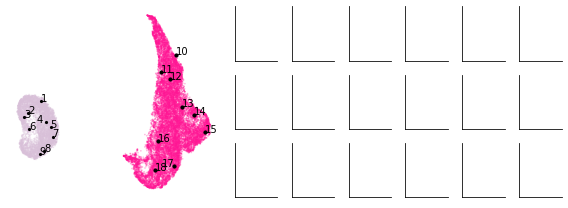

In [123]:
save = False

save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_1/supplement/'

if species in ['MU', 'MZ']: 
    #set up the axes
    fig, axes = plt.subplot_mosaic(mosaic="AAAABCDEFG;AAAAHIJKLM;AAAANOPQRS", 
                                   figsize=[8,3], 
                                   layout='tight')

    # #parameters
    label_color_dict = {1: 'deeppink', 0: 'thistle', -1:'thistle'}


    num_freq_bins=128
    num_time_bins=128
    dot_size = 10
    dot_alpha = 1

    #plot the umap
    axes["A"].scatter(
        df_umap['umap1'],
        df_umap['umap2'],
        c = df_umap['label'].map(label_color_dict),
        s = .5,
        alpha = .25, 
        cmap='viridis')

    USV_spec_axes = ["B", "C", "D", "H", "I", "J", "N", "O", "P"]
    cry_spec_axes = ["E", "F", "G", "K", "L", "M", "Q", "R", "S"]
    all_spec_axes  = USV_spec_axes + cry_spec_axes

    #remove ticks
    axes["A"].set_xticks([], [])
    axes["A"].set_yticks([], [])
    axes["A"].axis('off')
    sns.despine()
    for ax in all_spec_axes:
        axes[ax].set_xticks([], [])
        axes[ax].set_yticks([], [])
    fig.subplots_adjust(wspace=0, hspace = 0)

    #sample example vocalizations
    if species not in ['MU', 'MZ']:
        USV_examples = df_umap.loc[df_umap['label'] == 0].sample(n=9, random_state=USV_seed)
        cry_examples = df_umap.loc[df_umap['label'] == 1].sample(n=9, random_state=cry_seed)
    else:
        USV_examples = df_umap.sample(n=18, random_state=USV_seed)

    #overlay them on the umap as black dots
    axes["A"].scatter(
        USV_examples['umap1'],
        USV_examples['umap2'],
        c = 'black',
        s = dot_size,
        alpha = dot_alpha, 
        linewidth=0)

    #overlay them on the umap plot as black dots
    if species not in ['MU', 'MZ']:
        axes["A"].scatter(
            cry_examples['umap1'],
            cry_examples['umap2'],
            c = 'black',
            s = dot_size,
            alpha = dot_alpha)

    #label them so you know which spec goes with which axis
    USV_examples = USV_examples.sort_values(by='umap2', ascending=False)
    USV_examples['plot_axis'] = USV_spec_axes + cry_spec_axes

    txt = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15,16,17,18]
    for txt, umap1, umap2 in zip(txt,USV_examples['umap1'], USV_examples['umap2']):
        if txt == 4:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(-10,0), textcoords = 'offset points')
        elif txt == 7:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')
        else:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')

    txt = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15,16,17,18]
    for ax,label in zip(all_spec_axes, txt):
        columns_to_drop = ['source_file', 'umap1', 'umap2', 'label', 'plot_axis']

        to_plot = USV_examples.loc[USV_examples['plot_axis'] == ax].drop(columns = columns_to_drop)

        img = np.array(to_plot).reshape((num_freq_bins, num_time_bins))
        axes[ax].axis('off')
        axes[ax].imshow(img, origin = 'lower', extent = (num_freq_bins, 0, num_time_bins, 0 ))

        axes[ax].text(118, 15, label, ha="center", va="center", color="w", fontsize=9, fontname='Arial')

else:
    
    #set up the axes
    fig, axes = plt.subplot_mosaic(mosaic="AAAABCDEFG;AAAAHIJKLM;AAAANOPQRS", 
                                   figsize=[8,3], 
                                   layout='tight')

    # #parameters
    label_color_dict = {1: 'deeppink', 0: 'thistle', -1:'thistle'}



    num_freq_bins=128
    num_time_bins=128
    dot_size = 10
    dot_alpha = 1

    #plot the umap
    axes["A"].scatter(
        df_umap['umap1'],
        df_umap['umap2'],
        c = df_umap['label'].map(label_color_dict),
        s = .5,
        alpha = .25, 
        cmap='viridis')

    USV_spec_axes = ["B", "C", "D", "H", "I", "J", "N", "O", "P"]
    cry_spec_axes = ["E", "F", "G", "K", "L", "M", "Q", "R", "S"]

    #remove ticks
    axes["A"].set_xticks([], [])
    axes["A"].set_yticks([], [])
    axes["A"].axis('off')
    sns.despine()
    for ax in all_spec_axes:
        axes[ax].set_xticks([], [])
        axes[ax].set_yticks([], [])
    fig.subplots_adjust(wspace=0, hspace = 0)

    #sample example vocalizations
    USV_examples = df_umap.loc[df_umap['label'] == 0].sample(n=9, random_state=USV_seed)
    cry_examples = df_umap.loc[df_umap['label'] == 1].sample(n=9, random_state=cry_seed)

    #overlay them on the umap as black dots
    axes["A"].scatter(
        USV_examples['umap1'],
        USV_examples['umap2'],
        c = 'black',
        s = dot_size,
        alpha = dot_alpha, 
        linewidth=0)

    axes["A"].scatter(
        cry_examples['umap1'],
        cry_examples['umap2'],
        c = 'black',
        s = dot_size,
        alpha = dot_alpha)

    #label them so you know which spec goes with which axis
    USV_examples = USV_examples.sort_values(by='umap2', ascending=False)
    cry_examples = cry_examples.sort_values(by='umap2', ascending=False)
    USV_examples['plot_axis'] = USV_spec_axes
    cry_examples['plot_axis'] = cry_spec_axes

    #annotate the dots with numbers and move some of them so they aren't on top of other numbers
    txt = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15,16,17,18]
    for txt, umap1, umap2 in zip(txt,USV_examples['umap1'], USV_examples['umap2']):

        if txt == 4:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(-10,0), textcoords = 'offset points')
        elif txt == 7:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')
        else:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')

    txt = [10,11,12,13,14,15,16,17,18]
    for txt, umap1, umap2 in zip(txt,cry_examples['umap1'], cry_examples['umap2']):
        if txt == 17:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(-12,0), textcoords = 'offset points')
        else:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')

    #put the spectrograms on the axis
    txt = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
    for ax,label in zip(all_spec_axes, txt):
        columns_to_drop = ['source_file', 'umap1', 'umap2', 'label', 'plot_axis']

        to_plot = USV_examples.loc[USV_examples['plot_axis'] == ax].drop(columns = columns_to_drop)

        print(to_plot.shape())
        img = np.array(to_plot).reshape((num_freq_bins, num_time_bins))
        
        axes[ax].axis('off')
        axes[ax].imshow(img, origin = 'lower', extent = (num_freq_bins, 0, num_time_bins, 0 ))

        axes[ax].text(118, 15, label, ha="center", va="center", color="w", fontsize=9, fontname='Arial')
        axes[ax].annotate(label,xy=(0,0), xytext=(.8,0), fontsize=9)

#     txt = [10,11,12,13,14,15,16,17,18]
#     for ax, label in zip(cry_spec_axes, txt):
#         columns_to_drop = ['source_file', 'umap1', 'umap2', 'label', 'plot_axis']

#         to_plot = cry_examples.loc[cry_examples['plot_axis'] == ax].drop(columns = columns_to_drop)

#         img = np.array(to_plot).reshape((num_freq_bins, num_time_bins))
#         axes[ax].axis('off')
#         axes[ax].imshow(img, origin = 'lower', extent = (num_freq_bins, 0, num_time_bins, 0 ))

#         axes[ax].text(115, 15, label, ha="center", va="center", color="w", fontsize=9, fontname='Arial')

#         axes[ax].annotate(label,xy=(0,0), xytext=(0,0), fontsize=9)

#     if save:
#         save_name = ('_').join([species,'spec_examples_20221013'+'.jpeg'])
#         plt.savefig(os.path.join(save_dir,save_name),dpi=600)
    


In [119]:
USV_examples

,0,1,2,3,4,5,6,7,8,9,...,16379,16380,16381,16382,16383,source_file,umap1,umap2,label,plot_axis
17670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,BW_28988x28929_ltr2_pup2_ch3_5900_f_309_309_fr...,-6.485963,3.890173,0,B
3878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,BW_29483x28930_ltr3_pup2_ch3_6500_f_331_326_fr...,-7.764054,2.938969,0,C
8457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,BW_28987x28928_ltr3_pup3_ch4_5900_f_329_302_fr...,-8.197188,2.666188,0,D
11708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,BW_29483x28930_ltr1_pup1_ch2_6200_f_289_307_fr...,-5.963829,2.274090,0,H
24500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,BW_29483x28930_ltr1_pup3_ch4_6100_f_285_291_fr...,-5.512311,1.845274,0,I
19376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,BW_31386x31477_ltr1_pup1_ch2_4000_m_363_309_fr...,-7.663684,1.699577,0,J
28405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,BW_28988x28929_ltr2_pup1_ch2_6300_m_310_319_fr...,-5.316420,1.132846,0,N
12844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,BW_28988x28929_ltr2_pup1_ch2_6300_m_310_319_fr...,-6.182320,0.002065,0,O
8480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,BW_29483x28930_ltr1_pup3_ch4_6100_f_285_291_fr...,-6.601426,-0.196263,0,P


In [116]:
USV_spec_axes

['B', 'C', 'D', 'H', 'I', 'J', 'N', 'O', 'P']

In [117]:
cry_spec_axes

['E', 'F', 'G', 'K', 'L', 'M', 'Q', 'R', 'S']

# Supplemental Figure ## (weights and heat loss)

# Supplemental Figure ## (inter-onset intervals)